<a href="https://colab.research.google.com/github/abhinashp25/Plant_Disease_Prediction/blob/main/Plant_Desies_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import random
random.seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_transforms = {
    'train': transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        path, label = self.samples[index]
        try:
            image = Image.open(path).convert("RGB")
        except (IOError, UnidentifiedImageError) as e:
            return self.__getitem__((index + 1) % len(self.samples))

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.samples)

In [10]:
#Import data from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)
data_dir = "/kaggle/input/plantdisease/PlantVillage"
full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
all_samples = full_dataset.samples
classes = full_dataset.classes
print("Classes:", classes)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [11]:
random.shuffle(all_samples)
n_total = len(all_samples)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val

train_samples = all_samples[:n_train]
val_samples   = all_samples[n_train:n_train+n_val]
test_samples  = all_samples[n_train+n_val:]

In [12]:
train_dataset = CustomImageDataset(train_samples, transform=data_transforms['train'])
val_dataset   = CustomImageDataset(val_samples, transform=data_transforms['val'])
test_dataset  = CustomImageDataset(test_samples, transform=data_transforms['test'])

In [13]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

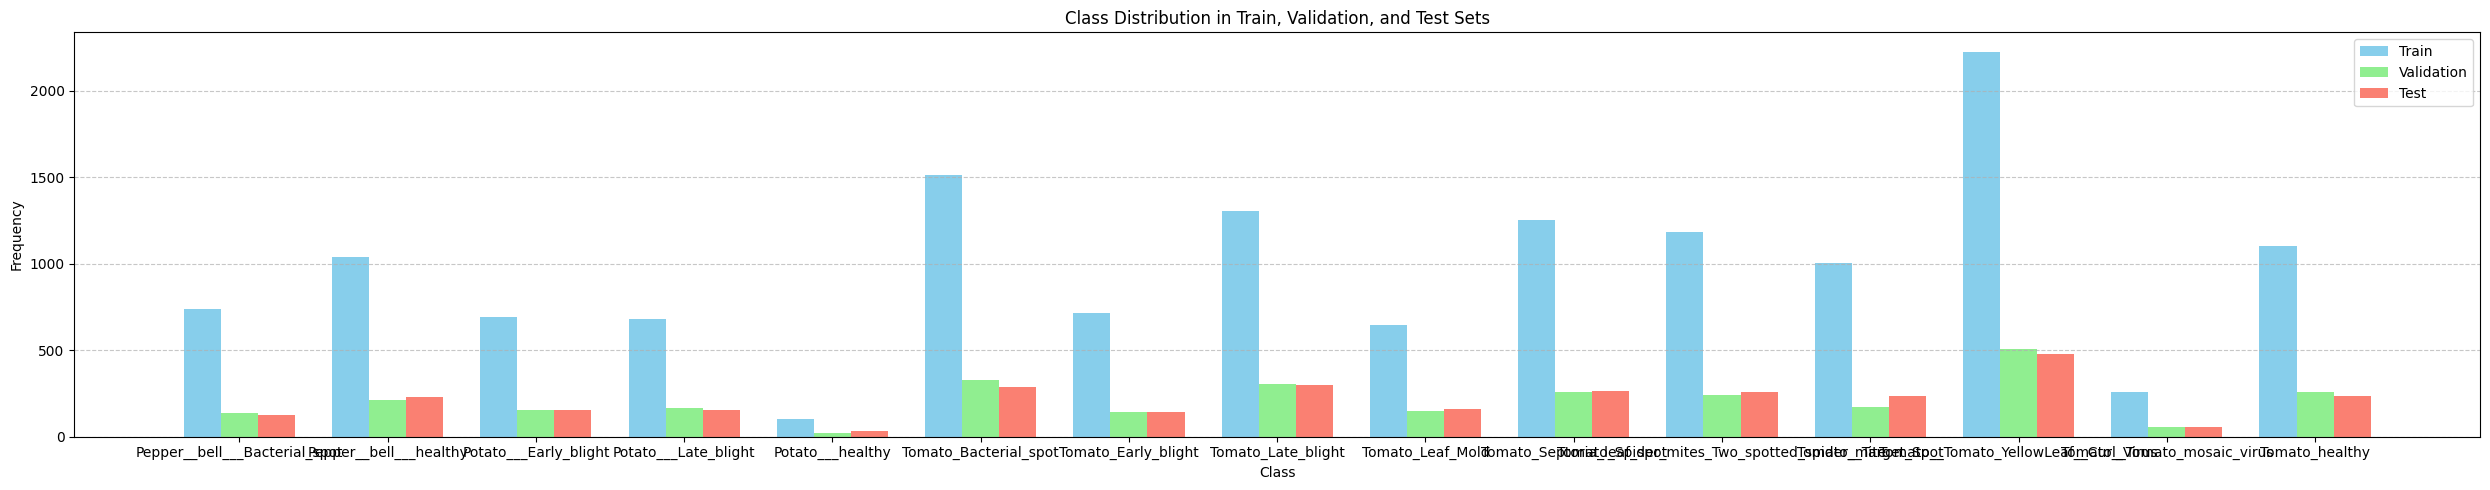

In [14]:
train_labels = [label for _, label in train_samples]
val_labels   = [label for _, label in val_samples]
test_labels  = [label for _, label in test_samples]

# Compute class counts using Counter
train_counter = Counter(train_labels)
val_counter   = Counter(val_labels)
test_counter  = Counter(test_labels)

# Create a list of class names (ensure ordering is consistent)
class_names = [classes[i] for i in range(len(classes))]
num_classes = len(class_names)

# Extract counts for each class in the same order
train_counts = [train_counter.get(i, 0) for i in range(num_classes)]
val_counts   = [val_counter.get(i, 0) for i in range(num_classes)]
test_counts  = [test_counter.get(i, 0) for i in range(num_classes)]

# Set up the positions for the bars
x = np.arange(num_classes)  # label locations
width = 0.25  # width of each bar

# Create the plot
plt.figure(figsize=(25, 5))
plt.bar(x - width, train_counts, width, label='Train', color='skyblue')
plt.bar(x,         val_counts,   width, label='Validation', color='lightgreen')
plt.bar(x + width, test_counts,  width, label='Test', color='salmon')

plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xticks(x, class_names)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.axis('off')

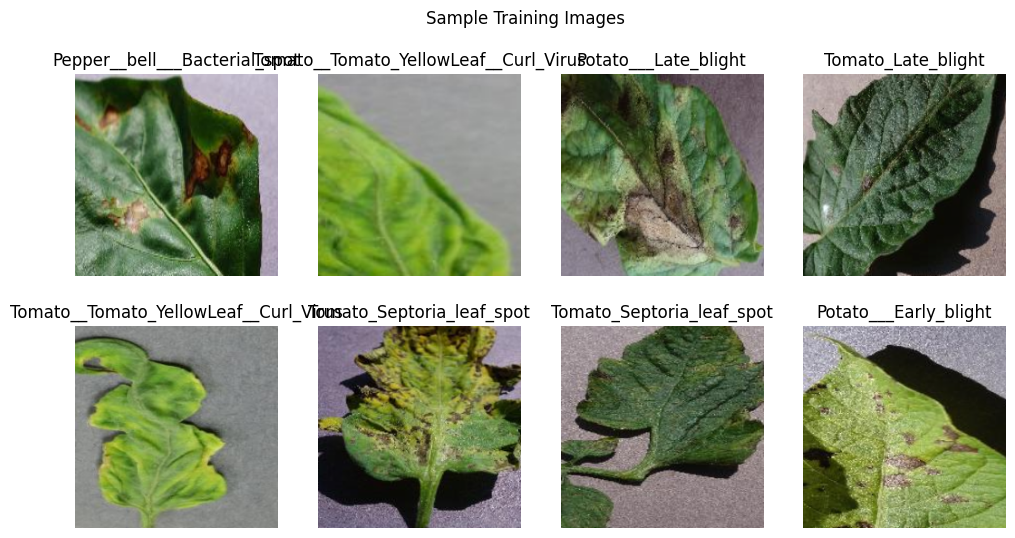

In [16]:
inputs, labels = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(min(8, inputs.size(0))):
    plt.subplot(2, 4, i+1)
    imshow(inputs[i], title=classes[labels[i]])
plt.suptitle("Sample Training Images")
plt.show()

In [18]:
num_epochs = 15

In [19]:
device = torch.device("cuda")

In [20]:
model = models.efficientnet_b0(weights=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(classes))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
efficientnet_train_losses, efficientnet_val_losses = [], []
efficientnet_train_accuracies, efficientnet_val_accuracies = [], []

In [23]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc  = running_corrects.double() / len(train_dataset)
    efficientnet_train_losses.append(epoch_loss)
    efficientnet_train_accuracies.append(epoch_acc.item())

    # Validation phase
    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss_val += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects_val += torch.sum(preds == labels.data)

    epoch_loss_val = running_loss_val / len(val_dataset)
    epoch_acc_val  = running_corrects_val.double() / len(val_dataset)
    efficientnet_val_losses.append(epoch_loss_val)
    efficientnet_val_accuracies.append(epoch_acc_val.item())

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}")

Epoch 1/15 | Train Loss: 0.7965 Acc: 0.7837 | Val Loss: 0.1453 Acc: 0.9580
Epoch 2/15 | Train Loss: 0.2133 Acc: 0.9340 | Val Loss: 0.0840 Acc: 0.9761
Epoch 3/15 | Train Loss: 0.1559 Acc: 0.9523 | Val Loss: 0.0439 Acc: 0.9871
Epoch 4/15 | Train Loss: 0.1276 Acc: 0.9592 | Val Loss: 0.0592 Acc: 0.9803
Epoch 5/15 | Train Loss: 0.1117 Acc: 0.9668 | Val Loss: 0.0433 Acc: 0.9893
Epoch 6/15 | Train Loss: 0.0932 Acc: 0.9708 | Val Loss: 0.0354 Acc: 0.9890
Epoch 7/15 | Train Loss: 0.0842 Acc: 0.9728 | Val Loss: 0.0308 Acc: 0.9926
Epoch 8/15 | Train Loss: 0.0806 Acc: 0.9740 | Val Loss: 0.0307 Acc: 0.9922
Epoch 9/15 | Train Loss: 0.0783 Acc: 0.9743 | Val Loss: 0.0276 Acc: 0.9906
Epoch 10/15 | Train Loss: 0.0724 Acc: 0.9763 | Val Loss: 0.0322 Acc: 0.9897
Epoch 11/15 | Train Loss: 0.0639 Acc: 0.9793 | Val Loss: 0.0251 Acc: 0.9910
Epoch 12/15 | Train Loss: 0.0606 Acc: 0.9799 | Val Loss: 0.0188 Acc: 0.9952
Epoch 13/15 | Train Loss: 0.0615 Acc: 0.9798 | Val Loss: 0.0407 Acc: 0.9900
Epoch 14/15 | Train L

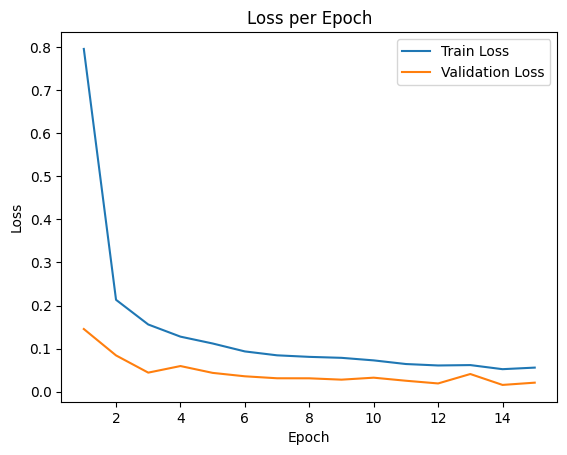

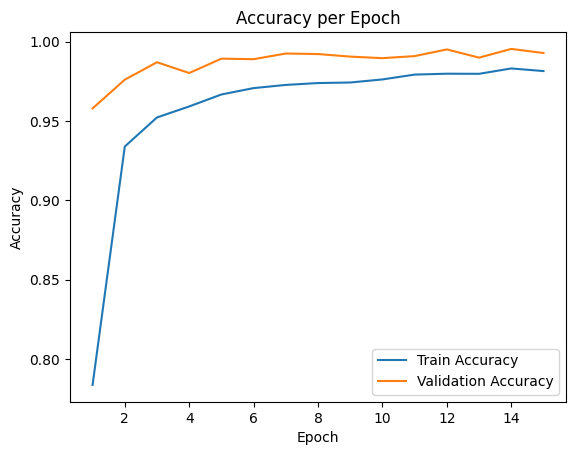

In [24]:
plt.figure()
plt.plot(range(1, num_epochs+1), efficientnet_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), efficientnet_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), efficientnet_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), efficientnet_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

In [25]:
import json
import torch
import os
pth_save_path = "efficientnet_model.pth"
torch.save(model.state_dict(), pth_save_path)

json_save_path = "efficientnet_model.json"
serializable_dict = {}
for key, value in model.state_dict().items():
    serializable_dict[key] = value.cpu().numpy().tolist()

with open(json_save_path, 'w') as f:
    json.dump(serializable_dict, f)

In [26]:
model = models.resnet50(weights=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
resnet_train_losses, resnet_val_losses = [], []
resnet_train_accuracies, resnet_val_accuracies = [], []

In [29]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc  = running_corrects.double() / len(train_dataset)
    resnet_train_losses.append(epoch_loss)
    resnet_train_accuracies.append(epoch_acc.item())

    # Validation phase
    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss_val += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects_val += torch.sum(preds == labels.data)

    epoch_loss_val = running_loss_val / len(val_dataset)
    epoch_acc_val  = running_corrects_val.double() / len(val_dataset)
    resnet_val_losses.append(epoch_loss_val)
    resnet_val_accuracies.append(epoch_acc_val.item())

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}")

Epoch 1/15 | Train Loss: 0.4264 Acc: 0.8730 | Val Loss: 0.1020 Acc: 0.9651
Epoch 2/15 | Train Loss: 0.1870 Acc: 0.9404 | Val Loss: 0.0494 Acc: 0.9851
Epoch 3/15 | Train Loss: 0.1421 Acc: 0.9555 | Val Loss: 0.0491 Acc: 0.9848
Epoch 4/15 | Train Loss: 0.1283 Acc: 0.9585 | Val Loss: 0.1182 Acc: 0.9680
Epoch 5/15 | Train Loss: 0.1133 Acc: 0.9632 | Val Loss: 0.0451 Acc: 0.9851
Epoch 6/15 | Train Loss: 0.1028 Acc: 0.9661 | Val Loss: 0.0552 Acc: 0.9813
Epoch 7/15 | Train Loss: 0.0903 Acc: 0.9706 | Val Loss: 0.0488 Acc: 0.9848
Epoch 8/15 | Train Loss: 0.0975 Acc: 0.9679 | Val Loss: 0.0405 Acc: 0.9868
Epoch 9/15 | Train Loss: 0.0918 Acc: 0.9698 | Val Loss: 0.0595 Acc: 0.9771
Epoch 10/15 | Train Loss: 0.0838 Acc: 0.9709 | Val Loss: 0.0518 Acc: 0.9851
Epoch 11/15 | Train Loss: 0.0773 Acc: 0.9754 | Val Loss: 0.0457 Acc: 0.9848
Epoch 12/15 | Train Loss: 0.0754 Acc: 0.9747 | Val Loss: 0.0263 Acc: 0.9922
Epoch 13/15 | Train Loss: 0.0714 Acc: 0.9769 | Val Loss: 0.0575 Acc: 0.9829
Epoch 14/15 | Train L

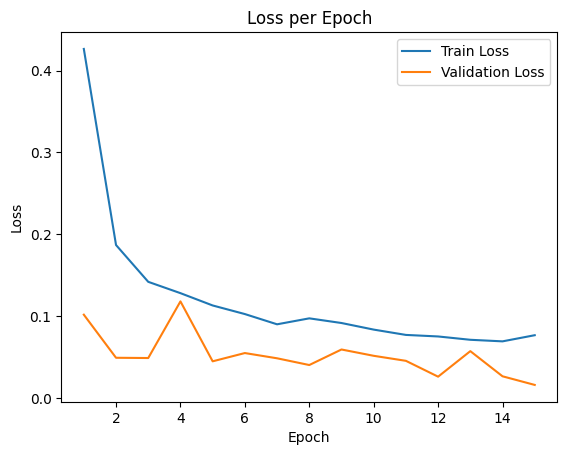

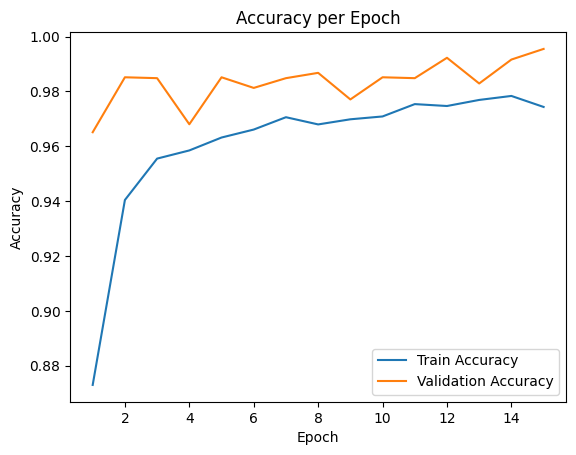

In [30]:
plt.figure()
plt.plot(range(1, num_epochs+1), resnet_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), resnet_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), resnet_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), resnet_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

In [31]:
import json
import torch
import os
pth_save_path = "resnet50_model.pth"
torch.save(model.state_dict(), pth_save_path)

json_save_path = "resnet50_model.json"
serializable_dict = {}
for key, value in model.state_dict().items():
    serializable_dict[key] = value.cpu().numpy().tolist()

with open(json_save_path, 'w') as f:
    json.dump(serializable_dict, f)

### Predict Disease from a givien Image

Enter the path to your image file below. Make sure the image is accessible in the Colab environment.

In [43]:
#@title Enter your image path
image_to_predict_path = "/content/tryingLeaf.jpg" #@param {type:"string"}

if image_to_predict_path:
    predicted_class = predict_image(model_efficientnet, image_to_predict_path, device, classes, data_transforms['test'])
    if predicted_class:
        print(f"The predicted disease for the image is: {predicted_class}")
else:
    print("Please provide an image path.")

The predicted disease for the image is: Potato___Early_blight
